In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import pickle

from BayesianNN import BayesianRegressorWrapper, RegressionSampler

### Base network classes
1. Linear regression
2. FFN with 2 layers, 10 hidden neurons per layer, ReLU activation function

In [2]:
class LR(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, i):
        return self.linear(i)

In [3]:
class FFN(nn.Module):
    def __init__(self, input_size=1, hidden1_size=10, hidden2_size=10, output_size=1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        
    def forward(self, i):
        x = F.relu(self.fc1(i))
        x = F.relu(self.fc2(x))
        o = self.fc3(x)
        return o

### Simulate linear data

In [50]:
N = 500
input_size = 4
output_size = 1
output_sd = 1.5

w = 8 * torch.randn(input_size, output_size)
print(w)
X = torch.randn(N, input_size)
y_mean = 10 + torch.matmul(X, w)
y = y_mean + torch.randn(N, 1) * output_sd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

tensor([[ -3.0944],
        [-10.3765],
        [-14.1995],
        [  8.2706]])


### Linear model

In [52]:
start = time.time()
torch.manual_seed(1)
base_model = LR(input_size=input_size, output_size=output_size)
bayesian_model = BayesianRegressorWrapper(base_model)
sampler = RegressionSampler(bayesian_model, X_train, y_train, X_test, y_test, w_prop_sd=0.10, tausq_prop_sd=0.10)

epochs = 5000
for i in range(epochs):
    sampler.sample(evaluate_on_test=True)
    if (i + 1) % (int(epochs / 5)) == 0:
        print(f"Done {i + 1} / {epochs}")
        print(f"Time taken: {np.round(time.time() - start, 2)}")
        print(f'Acceptance rate: {sampler.accept_counter / (i + 1)}')
        
print(f'Acceptance rate: {sampler.accept_counter / epochs}')

end = time.time()

print(f"Time taken: {np.round(end - start, 2)}s")

Done 1000 / 5000
Time taken: 1.92
Acceptance rate: 0.361
Done 2000 / 5000
Time taken: 3.92
Acceptance rate: 0.2775
Done 3000 / 5000
Time taken: 5.9
Acceptance rate: 0.242
Done 4000 / 5000
Time taken: 7.78
Acceptance rate: 0.232
Done 5000 / 5000
Time taken: 9.57
Acceptance rate: 0.2258
Acceptance rate: 0.2258
Time taken: 9.57s


### Examine plots

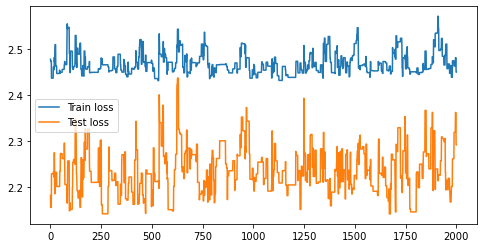

In [53]:
burn_in = 3000

plt.figure(figsize=(8, 4))
plt.plot(sampler.container.loss_list[burn_in:], label="Train loss")
plt.plot(sampler.container.test_loss_list[burn_in:], label="Test loss")
plt.legend()

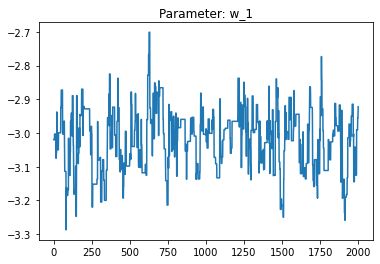

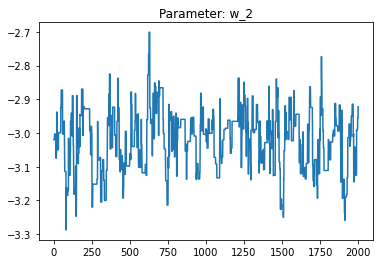

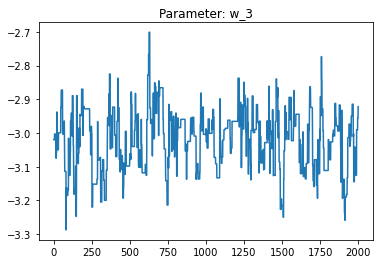

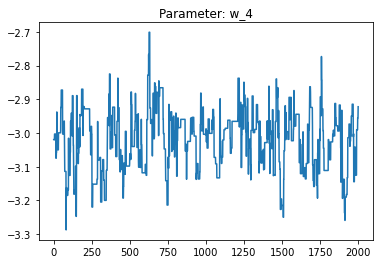

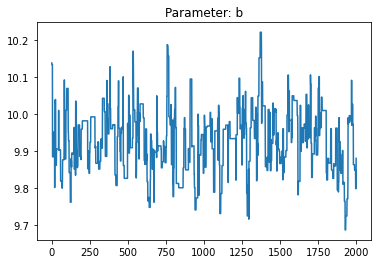

In [54]:
for i in range (len(w)):
    plt.figure()
    plt.title(f"Parameter: w_{i + 1}")
    plt.plot([float(sampler.container.w_list[i][0][0, 0]) for i in range(burn_in, epochs)])
plt.figure()
plt.title(f"Parameter: b")
plt.plot([float(sampler.container.w_list[i][1][0]) for i in range(burn_in, epochs)])

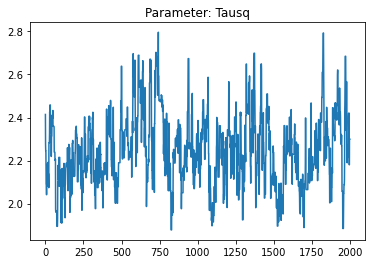

In [22]:
plt.figure()
plt.title("Parameter: Tausq")
plt.plot(sampler.container.tausq_list[burn_in:])

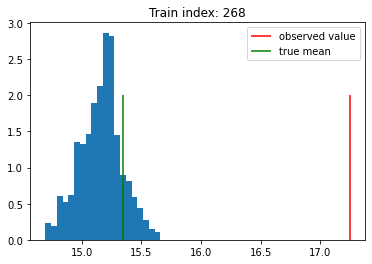

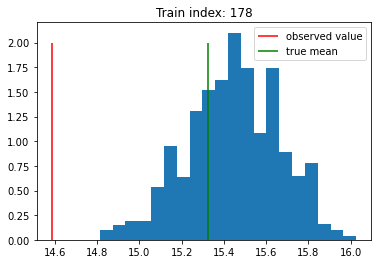

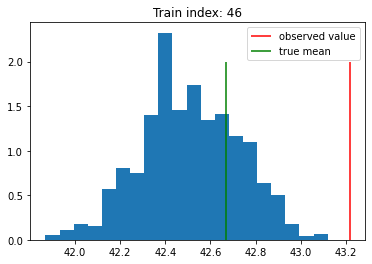

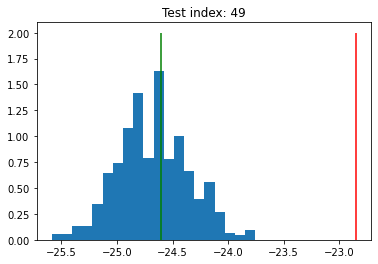

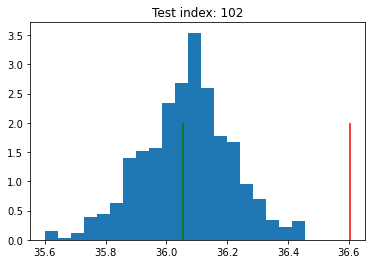

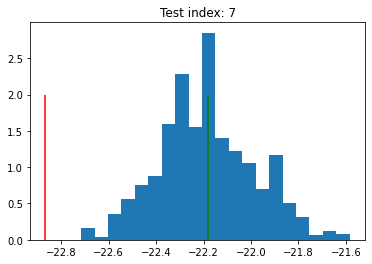

In [55]:
for i in range(3):
    plt.figure()
    idx = np.random.randint(0, len(y_train))
    plt.title(f"Train index: {idx}")
    plt.hist(
        torch.tensor([sampler.container.y_pred_train_list[i][idx] for i in range(burn_in, epochs + 1)]).numpy(),
        bins=20, density=True)
    plt.vlines(x=y_train[idx].numpy(), ymin=0, ymax=2, color="red", label="observed value")
    plt.vlines(x=(10 + torch.matmul(X_train[idx], w)).numpy(), ymin=0, ymax=2, color="green", label="true mean")
    plt.legend()

for i in range(3):
    plt.figure()
    idx = np.random.randint(0, len(y_test))
    plt.title(f"Test index: {idx}")
    plt.hist(
        torch.tensor([sampler.container.y_pred_test_list[i][idx] for i in range(burn_in, epochs + 1)]).numpy(),
        bins=20, density=True)
    plt.vlines(x=y_test[idx].numpy(), ymin=0, ymax=2, color="red", label="observed value")
    plt.vlines(x=(10 + torch.matmul(X_test[idx], w)).numpy(), ymin=0, ymax=2, color="green", label="true mean")

In [56]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

print(f"True value: {w.numpy().reshape(-1), output_sd ** 2}")
print(f"Linear regression fitted values: {reg.intercept_, reg.coef_}")
print(f"Final bayesian network parameters: {list(base_model.parameters()), bayesian_model.tausq}")

True value: (array([ -3.0944326, -10.376523 , -14.1995325,   8.270636 ], dtype=float32), 2.25)
Linear regression fitted values: (array([9.946241], dtype=float32), array([[ -3.0010996, -10.494226 , -14.144877 ,   8.2965765]],
      dtype=float32))
Final bayesian network parameters: ([Parameter containing:
tensor([[ -2.9220, -10.4820, -14.1561,   8.3955]], requires_grad=True), Parameter containing:
tensor([9.8803], requires_grad=True)], 2.111765533521548)


### Feedforward Neural Network

In [69]:
start = time.time()
torch.manual_seed(1)
base_model = FFN(input_size=input_size, output_size=output_size)
bayesian_model = BayesianRegressorWrapper(base_model)
sampler = RegressionSampler(bayesian_model, X_train, y_train, X_test, y_test, 
                            w_prop_sd=0.025, tausq_prop_sd=0.025, lr=0.01)

epochs = 5000
for i in range(epochs):
    sampler.sample(evaluate_on_test=True)
    if (i + 1) % (int(epochs / 5)) == 0:
        print(f"Done {i + 1} / {epochs}")
        print(f"Time taken: {np.round(time.time() - start, 2)}")
        print(f'Acceptance rate: {sampler.accept_counter / (i + 1)}')
        
        
print(f'Acceptance rate: {sampler.accept_counter / epochs}')
# sampler.update_param_dist()

end = time.time()

print(f"Time taken: {np.round(end - start, 2)}s")

Done 1000 / 5000
Time taken: 4.34
Acceptance rate: 0.534
Done 2000 / 5000
Time taken: 8.19
Acceptance rate: 0.4685
Done 3000 / 5000
Time taken: 12.81
Acceptance rate: 0.3626666666666667
Done 4000 / 5000
Time taken: 16.69
Acceptance rate: 0.28125
Done 5000 / 5000
Time taken: 20.76
Acceptance rate: 0.2304
Acceptance rate: 0.2304
Time taken: 20.76s


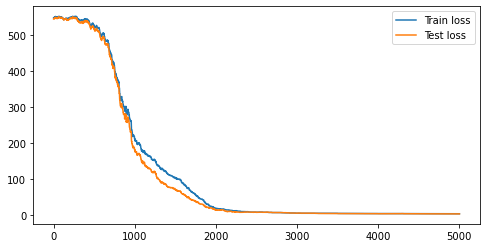

In [71]:
burn_in = 0

plt.figure(figsize=(8, 4))
plt.plot(sampler.container.loss_list[burn_in:], label="Train loss")
plt.plot(sampler.container.test_loss_list[burn_in:], label="Test loss")
plt.legend()

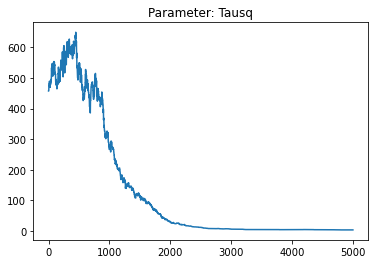

In [72]:
plt.figure()
plt.title("Parameter: Tausq")
plt.plot(sampler.container.tausq_list[burn_in:])

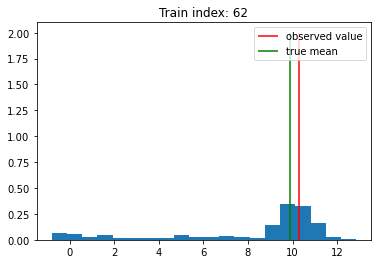

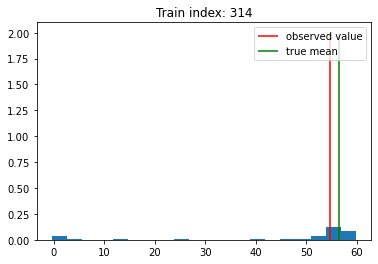

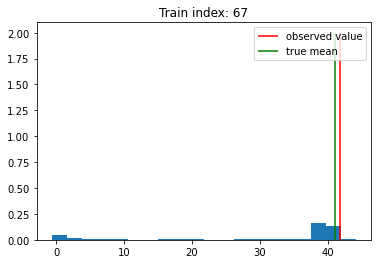

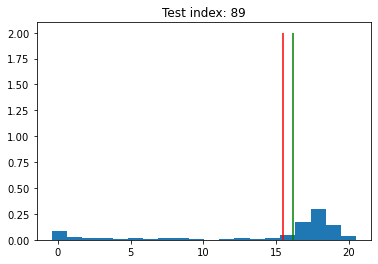

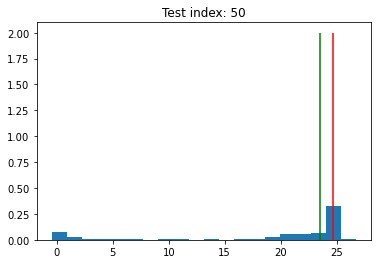

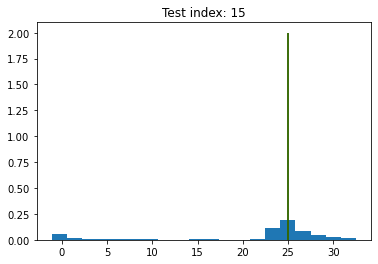

In [73]:
for i in range(3):
    plt.figure()
    idx = np.random.randint(0, len(y_train))
    plt.title(f"Train index: {idx}")
    plt.hist(
        torch.tensor([sampler.container.y_pred_train_list[i][idx] for i in range(burn_in, epochs + 1)]).numpy(),
        bins=20, density=True)
    plt.vlines(x=y_train[idx].numpy(), ymin=0, ymax=2, color="red", label="observed value")
    plt.vlines(x=(10 + torch.matmul(X_train[idx], w)).numpy(), ymin=0, ymax=2, color="green", label="true mean")
    plt.legend()

for i in range(3):
    plt.figure()
    idx = np.random.randint(0, len(y_test))
    plt.title(f"Test index: {idx}")
    plt.hist(
        torch.tensor([sampler.container.y_pred_test_list[i][idx] for i in range(burn_in, epochs + 1)]).numpy(),
        bins=20, density=True)
    plt.vlines(x=y_test[idx].numpy(), ymin=0, ymax=2, color="red", label="observed value")
    plt.vlines(x=(10 + torch.matmul(X_test[idx], w)).numpy(), ymin=0, ymax=2, color="green", label="true mean")

### CNN

In [157]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
data = load_digits()
encoder = OneHotEncoder()

In [159]:
X = torch.tensor(data['data'].reshape(-1, 1, 8, 8)).type(torch.float)
y = data['target']

y = torch.tensor(encoder.fit_transform(y.reshape(-1, 1)).toarray()).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [160]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(4 * 4 * 64, 16)
        self.fc2 = nn.Sequential(
            nn.Linear(16, output_size),
            nn.Softmax(dim=1)
        )
        
    def forward(self, i):
        x = self.layer1(i)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return self.fc2(x)

Done 30 / 150
Time taken: 17.91
Acceptance rate: 0.5333333333333333
Done 60 / 150
Time taken: 36.94
Acceptance rate: 0.4
Done 90 / 150
Time taken: 54.44
Acceptance rate: 0.32222222222222224
Done 120 / 150
Time taken: 71.81
Acceptance rate: 0.2833333333333333
Done 150 / 150
Time taken: 89.42
Acceptance rate: 0.24
Acceptance rate: 0.24
Time taken: 89.5s


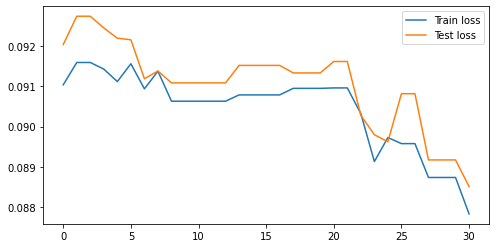

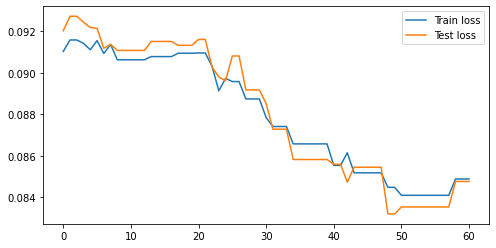

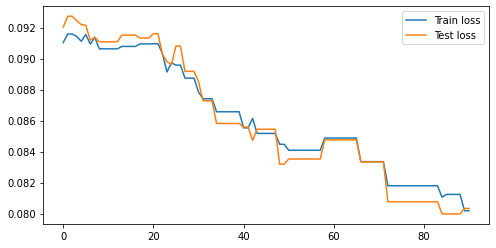

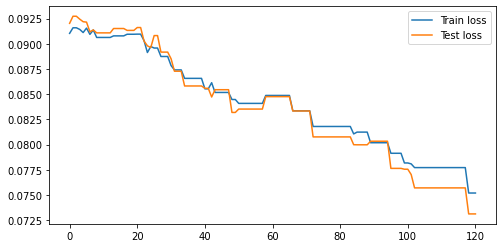

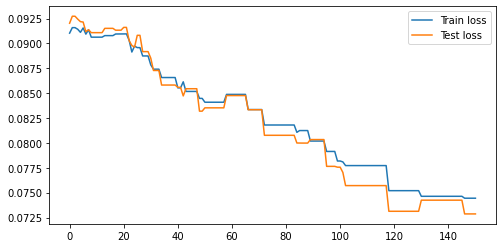

In [189]:
base_model = CNN(10)
bayesian_model = BayesianRegressorWrapper(base_model)
sampler = RegressionSampler(bayesian_model, X_train, y_train, X_test, y_test, lg_freq=0.60, lr=0.20,
                            w_prop_sd=0.01, tausq_prop_sd=0.01)

epochs = 150

start = time.time()
for i in range(epochs):
    sampler.sample(evaluate_on_test=True)
    if (i + 1) % (int(epochs / 5)) == 0:
        print(f"Done {i + 1} / {epochs}")
        print(f"Time taken: {np.round(time.time() - start, 2)}")
        print(f'Acceptance rate: {sampler.accept_counter / (i + 1)}')
        
print(f'Acceptance rate: {sampler.accept_counter / epochs}')

end = time.time()

print(f"Time taken: {np.round(end - start, 2)}s")

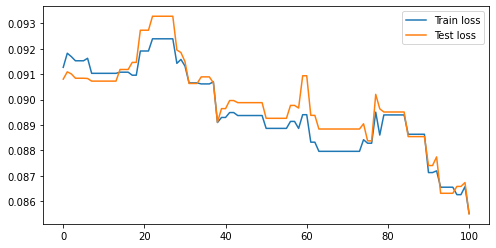

In [186]:
burn_in = 0

plt.figure(figsize=(8, 4))
plt.plot(sampler.container.loss_list[burn_in:], label="Train loss")
plt.plot(sampler.container.test_loss_list[burn_in:], label="Test loss")
plt.legend()

# Scratch

In [192]:
model = CNN(10)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.10)

epochs = 150
losses = []

start = time.time()
for i in range(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % (int(epochs / 5)) == 0:
        print(f"Done {i + 1} / {epochs}")
        print(f"Time taken: {np.round(time.time() - start, 2)}")
end = time.time()

Done 30 / 150
Time taken: 8.23
Done 60 / 150
Time taken: 16.99
Done 90 / 150
Time taken: 28.45
Done 120 / 150
Time taken: 38.21
Done 150 / 150
Time taken: 46.67


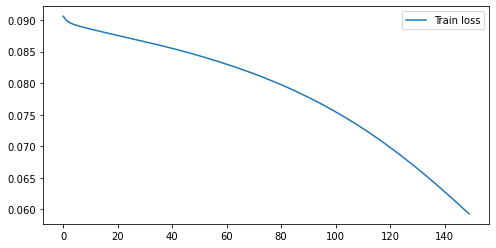

In [193]:
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Train loss")
plt.legend()